In [1]:
import numpy as np

from matplotlib import pyplot as plt
import math

import time
import random
import networkx as nx
import os

import sys
path='Bibliotheken/'
res2 = os.listdir(path)
print(res2)
sys.path.append(path)

import Steady_State_Calculation_Spanning_Trees as auto
import PDF_Flux_entropy as PDF

['Steady_State_Calculation_Spanning_Trees.py', 'Kinesin_Parameters.py', 'Analytic_Quantities.py', 'histogram.eps', 'PDF_Flux_entropy.py', '__pycache__']


In [2]:
exit_open = 1/5e-3
A = np.array([[0,2e3,0], [4e3,0,4e3], [0,exit_open,0]])
print('A = \n', A)
G=auto.Matrix2Graph(A)
p=auto.steady_state(G)
print('steady state p = ',p)

A = 
 [[   0. 2000.    0.]
 [4000.    0. 4000.]
 [   0.  200.    0.]]
steady state p =  [0.08695652 0.04347826 0.86956522]


In [3]:
# Relaxation into steady state for large T
p_sim = PDF.simulation_prob(matrix=A, startState=1, T=1)
print('simulated probability ,  p = ', p_sim)

simulated probability ,  p =  [0.09851041 0.04399463 0.85988133]


In [4]:
def sum_up(matrix, row):
    res=0
    for i in range(len(matrix)):
        res=res+matrix[row][i]
        
    return res

def compare(vector, number):
    res=0
    for x in vector:
        if number<=vector[res]:
            return res
        else:
            res=res+1
    return -1

def rate_interval(matrix, row):
    vec=[]
    for col in range(1,len(matrix)+1):
        sum=0
        for i in range(col):
            sum=sum+matrix[row][i]
        res=sum/sum_up(matrix, row)
        vec.append(res)
    #print (vec)
    return vec


#initialisierung 
def init(matrix):
    sumUp=[]
    rateInterval=[]
    for row in range(len(matrix)):
        sumUp.append(sum_up(matrix,row))
        rateInterval.append(rate_interval(matrix,row))
    return [sumUp, rateInterval]
    #print(sumUp)
    #print(rateInterval)



def timestep(oldstate, t1, sumUp, rateInterval):
    dt=-np.log(np.random.random_sample() )/sumUp[oldstate]
    #print(dt)
    t1=t1+dt
    z1=np.random.random_sample()
    #print(z1)
    newstate=compare(rateInterval[oldstate], z1)
    #print(newstate)
    return [newstate, t1]

def simulation_traj(matrix, startState, T, sampling_step):
    [sumUp, rateInterval]=init(matrix)
    t=0.0
    state=startState
    #memory for trajectory
    TIME=[]
    states=[]

    while t<T:
        [state, t]=timestep(state, t, sumUp, rateInterval)
        TIME.append(t)
        states.append(state)
    prob=np.zeros(len(matrix))
    
    N = int(T/sampling_step)
    sample_states = -np.ones(N)
    sample_step = 0
    
    count_too_small = 0
    for i in range(len(TIME)-1):
        dt_gillespie = TIME[i+1]-TIME[i]
        n = int(dt_gillespie/sampling_step)
        if n < 1:
            count_too_small = count_too_small+1
        else:
            sample_states[sample_step:sample_step+n] = states[i]
            sample_step = sample_step +n
        prob[ states[i] ]=prob[ states[i] ] + dt_gillespie
    prob=1.0/T*prob
    print('number of Gillespie steps', len(states))
    print('number of sample steps ', sample_step)
    print('number of transitions not seen by sample step', count_too_small)
    return [prob, sample_states]

In [5]:
T = 1
sampling_step = 1e-6
[prob, sample_states] = simulation_traj(matrix=A, startState=1, T=T, sampling_step=sampling_step)

# make state 0 and 1 indistinguishable
sample_indistinguishable = sample_states.copy()
index = sample_states == 1
sample_indistinguishable[index] = 0

print('steady state p = ',p)
print('Gillespie prob = ', prob)
N = len(sample_states)
print('N = ', N)
print('min = ', sample_states.min())
print('max = ', sample_states.max())
state0 = np.count_nonzero(sample_states == 0)
state1 = np.count_nonzero(sample_states == 1)
state2 = np.count_nonzero(sample_states == 2)
error = np.count_nonzero(sample_states == -1)
print('number of -1 states (error)', error)
p_sample = [state0/N, state1/N, state2/N ]
print('p_sample = ', p_sample)

number of Gillespie steps 734
number of sample steps  999919
number of transitions not seen by sample step 5
steady state p =  [0.08695652 0.04347826 0.86956522]
Gillespie prob =  [0.10215505 0.04257229 0.85555159]
N =  1000000
min =  -1.0
max =  2.0
number of -1 states (error) 81
p_sample =  [0.102066, 0.04239, 0.855463]


In [6]:
# Adding noise
std_noise1 = 0.1
noise1 = np.random.normal(0, std_noise1,N)
print(len(noise1))
print(len(sample_states))
signal_noise1 = sample_indistinguishable + noise1

std_noise2 = 0.2
noise2 = np.random.normal(0, std_noise2,N)
signal_noise2 = sample_indistinguishable + noise2

1000000
1000000


In [7]:
[hist1, bin_edges1] = np.histogram(signal_noise1, density=True, bins=100)
[hist2, bin_edges2] = np.histogram(signal_noise2, density=True, bins=100)

# Write trajectories to output

In [20]:
folder = '3state_model_indistingushable'
if not os.path.exists(folder):
            os.makedirs(folder)
output = folder + '/sample_indistinguishable.txt'
np.savetxt(output, sample_states)

output = folder + '/signal_noise1.txt'
np.savetxt(output, signal_noise1)

output = folder + '/signal_noise2.txt'
np.savetxt(output, signal_noise1)

output = folder + '/matrix.txt'
np.savetxt(output, A)
        
output = folder + '/parameters.txt'
f = open(output, 'w')
f.write('T \t {:f} \n'.format(T))
f.write('sampling_step \t {:f} \n'.format(sampling_step))
f.write('std_noise1 \t {:f} \n'.format(std_noise1))
f.write('std_noise2 \t {:f} \n'.format(std_noise2))
f.close()

# plot timeseries

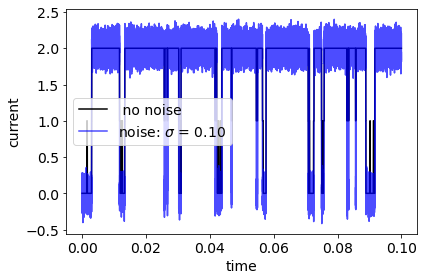

In [19]:
start = 0#10 * 1000
subset = int(0.1 * 1/sampling_step )
f_size =  14
fig, ax = plt.subplots()
t = np.arange(0,T,sampling_step)
ax.plot(t[0:subset], sample_states[start:start+subset], color='black', label=' no noise')
#ax.plot(t[0:subset], sample_indistinguishable[start:start+subset], color='green', label='indistinguishable closed states')
ax.plot(t[0:subset], signal_noise1[start:start+subset], color='blue', label='noise: $\sigma$ = %.2f' %std_noise1, alpha=0.7)
#ax.plot(t[0:subset], signal_noise2[0:subset], color='red', label='noise: $\sigma$ = %.2f' %std_noise2)
ax.set_xlabel('time', fontsize=f_size)
ax.set_ylabel('current', fontsize=f_size)
ax.tick_params(axis='both', labelsize=f_size)
ax.legend(prop={'size': 14})
fig.tight_layout()
fig.savefig(folder+'/timeseries.pdf')
plt.show()

# Plot distribution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


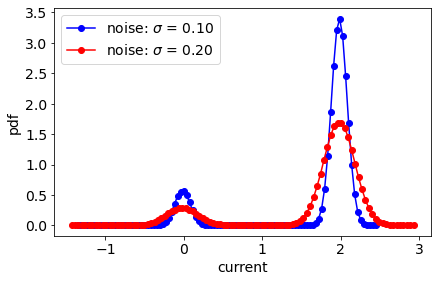

In [10]:
f_size =  14
fig, ax = plt.subplots()
#ax.plot([0,0], [0,p[0]], '-ok', color='black', label='steady-state distr.')
#ax.plot([1,1], [0,p[1]], '-ok', color='black')
#ax.plot([2,2], [0,p[2]], '-ok', color='black')
ax.plot(bin_edges1[:-1], hist1, '-ok', color='blue', label='noise: $\sigma$ = %.2f' %std_noise1)
ax.plot(bin_edges2[:-1], hist2, '-ok', color='red', label='noise: $\sigma$ = %.2f' %std_noise2)
ax.set_xlabel('current', fontsize=f_size)
ax.set_ylabel('pdf', fontsize=f_size)
ax.tick_params(axis='both', labelsize=f_size)
ax.legend(prop={'size': 14})
fig.tight_layout()
fig.savefig(folder+'/histogram.eps')
plt.show()

In [11]:
bla = np.array([0,1,2,0,1,2])

In [9]:
ind = bla == 1

In [10]:
ind

array([False,  True, False, False,  True, False])

In [12]:
bla[ind] = 0

In [13]:
bla

array([0, 0, 2, 0, 0, 2])